In [0]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=9d69e23d7e66335ccd3a5cd475792793bf9ec48e94676429fbcf76cdb811a840
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Using TensorFlow backend.


In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [0]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [0]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [0]:
new_data.describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
# new_data['day'] = new_data.index.day
# new_data['month'] = new_data.index.month

In [0]:
values = new_data.values
values

array([[0.70686364, 0.71567619, 0.9760859 , ..., 0.24522787, 0.01325557,
        0.11642582],
       [0.71108586, 0.71684587, 0.98087299, ..., 0.24798575, 0.01294331,
        0.11730605],
       [0.70298767, 0.71123755, 0.98165292, ..., 0.24800359, 0.01254469,
        0.1169644 ],
       ...,
       [0.69463742, 0.7628929 , 1.01887989, ..., 0.26060671, 0.01608338,
        0.10633377],
       [0.69829965, 0.76491195, 1.02699983, ..., 0.26248854, 0.01611572,
        0.10722665],
       [0.70013791, 0.76566166, 1.03238595, ..., 0.26333806, 0.01613655,
        0.10701276]])

In [0]:
values.shape

(1019, 15)

In [0]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [0]:
scaled

array([[0.25593185, 0.0386939 , 0.0439291 , ..., 0.15635943, 0.1321969 ,
        0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , ..., 0.19794154, 0.07479477,
        0.62116647],
       [0.2284193 , 0.        , 0.09297752, ..., 0.19821048, 0.00151777,
        0.6084964 ],
       ...,
       [0.16914749, 0.4503107 , 0.42097282, ..., 0.38823485, 0.65202737,
        0.21426368],
       [0.19514275, 0.46791172, 0.4925146 , ..., 0.41660833, 0.65797377,
        0.24737573],
       [0.2081914 , 0.47444773, 0.5399704 , ..., 0.42941713, 0.66180277,
        0.23944402]], dtype=float32)

In [0]:
plt.plot(scaled)
plt.show()

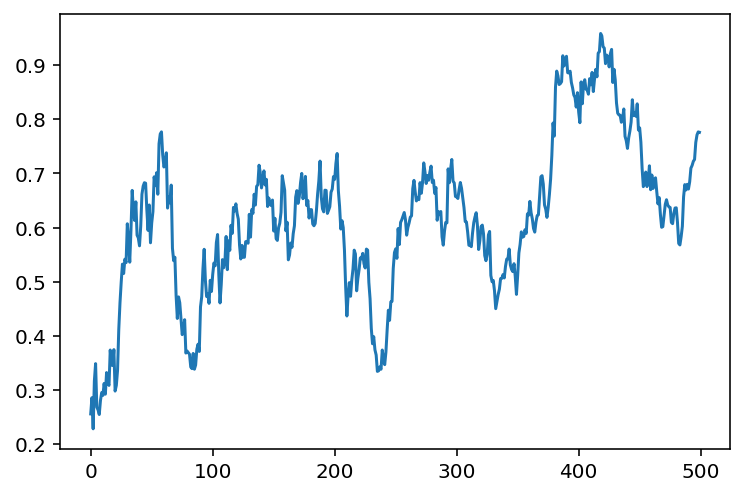

In [0]:
plt.plot(scaled[:,0][0:500])

In [0]:
# specify the number of lag hours
n_hours = 15
n_features = scaled.shape[1]
n_predict = 5
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)
print(reframed.shape)

(1000, 300)


In [0]:
reframed.head()

var1(t-15)  var2(t-15)  var3(t-15)  ...  var13(t+4)  var14(t+4)  var15(t+4)
15    0.255932    0.038694    0.043929  ...    0.278317    0.140624    0.635430
16    0.285902    0.048891    0.086106  ...    0.236566    0.103469    0.603783
17    0.228419    0.000000    0.092978  ...    0.233586    0.166093    0.605378
18    0.316959    0.119473    0.209049  ...    0.247510    0.204022    0.576828
19    0.348768    0.137392    0.313253  ...    0.255686    0.201628    0.579009

[5 rows x 300 columns]

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [0]:
# split into input and outputs
n_obs = n_hours * n_features

In [0]:
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 225) (500, 75)
(500, 15, 15) (500, 75) (500, 15, 15) (500, 75)


In [0]:
# design network
model = Sequential()
model.add(Dense(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
model.add(Dense(128, activation='relu'))
...
#model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(train_y.shape[1], activation='linear'))
model.compile(loss='mse', optimizer='adam')

Train on 500 samples, validate on 500 samples
Epoch 1/200
 - 0s - loss: 0.1993 - val_loss: 0.0385
Epoch 2/200
 - 0s - loss: 0.0685 - val_loss: 0.0576
Epoch 3/200
 - 0s - loss: 0.0426 - val_loss: 0.0522
Epoch 4/200
 - 0s - loss: 0.0395 - val_loss: 0.0458
Epoch 5/200
 - 0s - loss: 0.0297 - val_loss: 0.0352
Epoch 6/200
 - 0s - loss: 0.0224 - val_loss: 0.0349
Epoch 7/200
 - 0s - loss: 0.0181 - val_loss: 0.0265
Epoch 8/200
 - 0s - loss: 0.0146 - val_loss: 0.0245
Epoch 9/200
 - 0s - loss: 0.0125 - val_loss: 0.0252
Epoch 10/200
 - 0s - loss: 0.0102 - val_loss: 0.0268
Epoch 11/200
 - 0s - loss: 0.0089 - val_loss: 0.0235
Epoch 12/200
 - 0s - loss: 0.0082 - val_loss: 0.0221
Epoch 13/200
 - 0s - loss: 0.0073 - val_loss: 0.0223
Epoch 14/200
 - 0s - loss: 0.0068 - val_loss: 0.0223
Epoch 15/200
 - 0s - loss: 0.0064 - val_loss: 0.0219
Epoch 16/200
 - 0s - loss: 0.0060 - val_loss: 0.0222
Epoch 17/200
 - 0s - loss: 0.0058 - val_loss: 0.0222
Epoch 18/200
 - 0s - loss: 0.0055 - val_loss: 0.0216
Epoch 19/

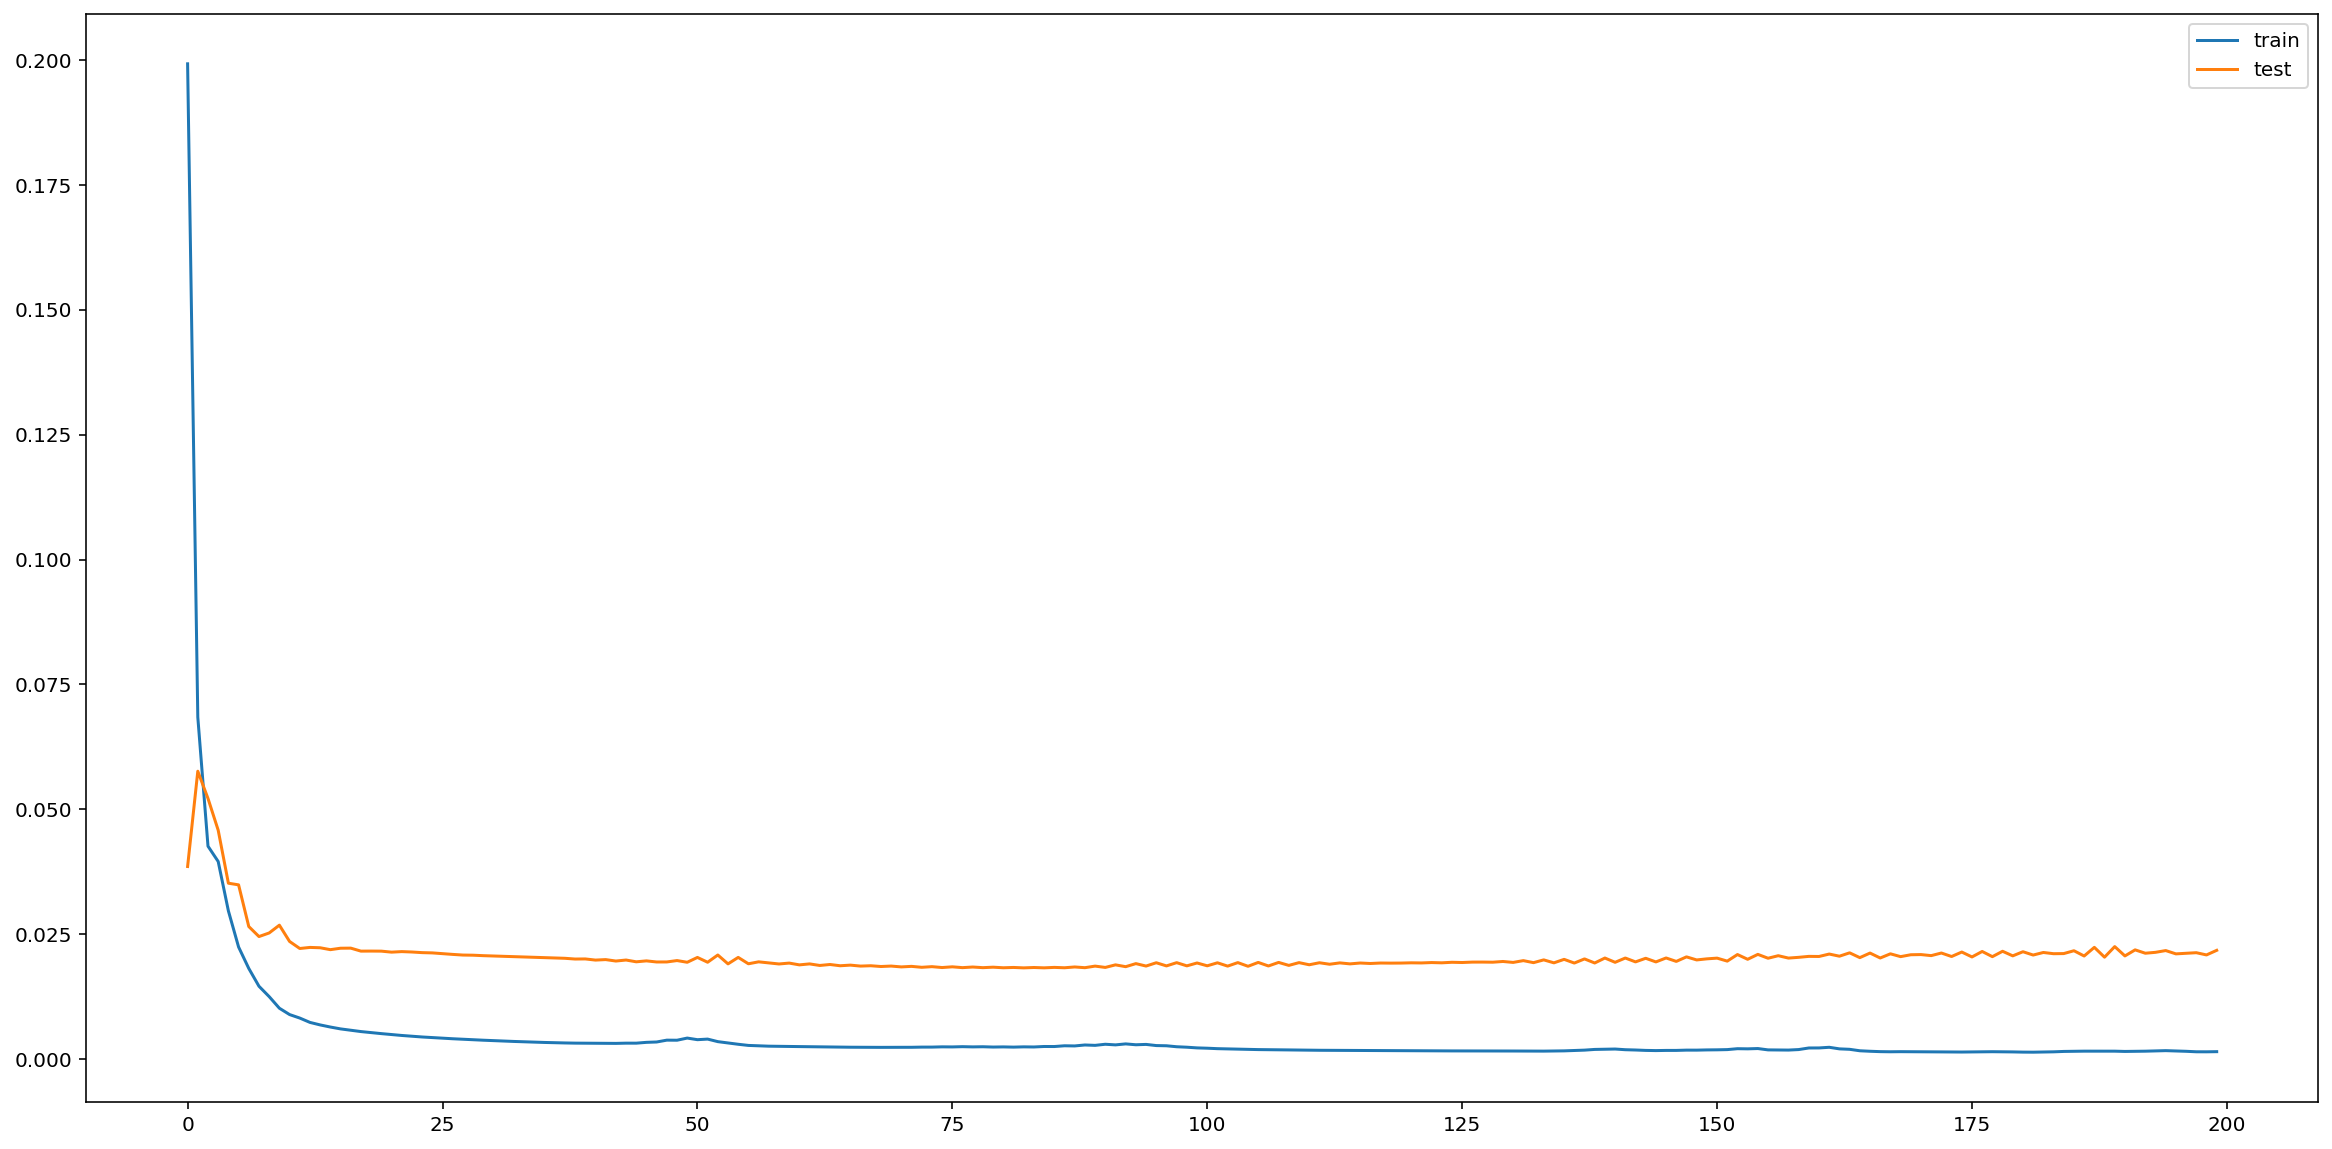

In [0]:
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
fig, ax = plt.subplots(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
y_hat = scaler.inverse_transform(test_y[:, 0:15])
y_pred = scaler.inverse_transform(model.predict(test_X)[:, 0:15])

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(y_hat[:, i], color='green')
    plt.plot(y_pred[:, i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def predict(start_arr, dist):
    res = np.array(start_arr)[:,0:n_features]
    
    for i in range(dist):
        pred = model.predict(np.array([res[-n_hours:]])).reshape(n_predict,n_features)
        res = np.concatenate((res, pred))
        if len(res) > dist + len(start_arr):
            break
    
    return res

In [0]:
res = []
i = 0
n = 3

while len(res) < len(test_y):
  temp_res = test_X[i]
  for j in range(n):
    temp_res = np.concatenate((temp_res, model.predict(np.array([temp_res[-n_hours:]])).reshape(n_predict,n_features)))
    res.append(temp_res[-1])
  i = i + n

y_pred = np.array(res)[:len(test_y)]
y_hat = scaler.inverse_transform(test_y[:, 0:n_features])
y_pred = scaler.inverse_transform(y_pred)

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(y_hat[:, i], color='green')
    plt.plot(y_pred[:, i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=e1303ef8282b02837b0c70b00915139a7dae8fe111053ff493eae8d216fe78a6
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
import ml_metrics as metrics

In [0]:
metrics.rmse(y_hat[:, -2], y_pred[:, -2])

0.00094068085

In [0]:
metrics.mae(y_hat[:, -2], y_pred[:, -2])

0.00076632784

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(scaler.inverse_transform(test_y[:,0:n_features])[:,i], color='green')
    plt.plot(scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])[:,i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

RMSE:

In [0]:
np.square(y_hat - y_pred).mean(axis = 0)

array([4.76674584e-04, 6.92712900e-04, 3.35558958e-04, 6.19936145e-06,
       1.22505835e-05, 7.05527258e-04, 7.34083122e-04, 1.05382419e-07,
       1.81505939e-07, 1.12228218e-08, 7.38748986e-06, 9.85095277e-04,
       1.29611173e-04, 8.84880535e-07, 3.20531872e-05], dtype=float32)

In [0]:
np.square(scaler.inverse_transform(test_y[:,0:n_features]) - scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])).mean(axis=0)

array([4.8706993e-03, 8.9238939e-04, 4.9414637e-04, 2.0679592e-05,
       4.6197361e-05, 2.6294321e-03, 1.9782051e-03, 1.2674290e-06,
       1.3150327e-07, 2.1300153e-07, 5.0030052e-05, 3.7647912e-03,
       2.3501436e-04, 4.7554045e-06, 1.1615565e-04], dtype=float32)